## PyTorch Tutorial!!!
In this assignment, you will be familiarized with the usage of the PyTorch library and how to build a model in two ways  
It's quite similar to TensorFlow
*   using the inbuilt layers in pytorch
*   using custom layers to replicate the same result

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math

In [2]:
# Using the GPU if it exists
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Loading and preprocessing the Data
We will directly be using the dataset included in literally any library that exists. MNIST really is THAT popular.  
Link: https://docs.pytorch.org/vision/0.9/datasets.html#mnist

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.53MB/s]


## Making a simple feedforward network

The following is a simple feedforward model with three layers:
* a flatten layer to convert our 28x28 images into a single array of length 784
* a dense layer of 128 neurons with the relu activation function
* finally a dense layer of 10 neurons with the softmax activation to get a distribution between the digits

In [4]:
# Build the model
SequentialNet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

### Training and Testing loops

In [5]:
# Training loop
def train(model, loader, optimizer, loss_fn, epochs=5):
    model.train() #sets the model to training mode like dropout layers are enabled
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Testing loop
def test(model, loader):
    model.eval() #sets the model to evaluation mode. Paired with torch.no_grad()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    print(f"Accuracy: {100 * correct / total:.2f}%")


### Training the sequential model

In [6]:
print("\nTraining SequentialNet")
sequential_model = SequentialNet.to(device)
optimizer_seq = optim.Adam(sequential_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


train(sequential_model, train_loader, optimizer_seq, loss_fn)
test(sequential_model, test_loader)


Training SequentialNet
Epoch 1, Loss: 375.3522
Epoch 2, Loss: 183.9505
Epoch 3, Loss: 130.8781
Epoch 4, Loss: 105.8865
Epoch 5, Loss: 88.8315
Accuracy: 96.67%


### Manually building the same network from scratch
You can use the simple sequential model we described above as a reference.

In [18]:
# Custom model
class ManualNet(nn.Module):
    def __init__(self):
        super(ManualNet, self).__init__()
        self.w1 = nn.Parameter(torch.randn(784, 128))
        self.b1 = nn.Parameter(torch.zeros(128))
        self.w2 = nn.Parameter(torch.randn(128, 64))
        self.b2 = nn.Parameter(torch.zeros(64))
        self.w3 = nn.Parameter(torch.randn(64, 10))
        self.b3 = nn.Parameter(torch.zeros(10))
        nn.init.kaiming_uniform_(self.w1, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.w2, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.w3, a=math.sqrt(5))
        # TODO: Define your paramters using nn.Parameters (the layers)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.matmul(x, self.w1) + self.b1
        x = torch.relu(x)
        x = torch.matmul(x, self.w2) + self.b2
        x = torch.relu(x)
        x = torch.matmul(x, self.w3) + self.b3
        return x
        # TODO: Do the forward pass using matrix multiplications and applying activation functions

### Training the manual model

In [19]:
print("\nTraining ManualNet")
manual_model = ManualNet().to(device)
optimizer_man = optim.SGD(manual_model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()



# TODO: Create a ManualNet object and call it manual_model. Train and test it


Training ManualNet


In [21]:

train(manual_model, train_loader, optimizer_man, loss_fn,10)
test(manual_model, test_loader)


# TODO: Create a ManualNet object and call it manual_model. Train and test it

Epoch 1, Loss: 119.2268
Epoch 2, Loss: 111.7812
Epoch 3, Loss: 105.0312
Epoch 4, Loss: 99.2767
Epoch 5, Loss: 93.9898
Epoch 6, Loss: 89.3202
Epoch 7, Loss: 85.0359
Epoch 8, Loss: 81.0744
Epoch 9, Loss: 77.5377
Epoch 10, Loss: 74.0711
Accuracy: 96.94%


### Visualize the outputs of the models

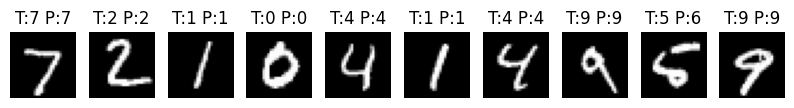

In [22]:
def visualize(model, loader, n=10):
    model.eval()
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    preds = model(x).argmax(dim=1)

    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(x[i].cpu().squeeze(), cmap='gray')
        plt.title(f"T:{y[i].item()} P:{preds[i].item()}")
        plt.axis('off')
    plt.show()

# visualize(manual_model, test_loader) # Uncomment this later
visualize(manual_model, test_loader)

## Assignment
* Load and preprocess CIFAR100 dataset (not CIFAR10)
* Build a feedforward network for it. You can experiment around with number of layers and and neurons in each layer and different activation functions
* You are allowed to use nn.functional. (convolutions _might_ make your accuracy better)

# Bonus Assignment
* Try the solving the "Titanic Survival Prediction" dataset from kaggle